# IMPORTS

In [1]:
import tensorflow as tf # For tensorflow
import numpy as np # For mathematical computations
import matplotlib.pyplot as plt # For plotting and Visualization
import seaborn as sns
from tensorflow.keras.layers import Input, Layer, Resizing, Rescaling, InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, RandomRotation, RandomFlip, RandomContrast, ReLU, Add, GlobalAveragePooling2D, Permute
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import cv2


# wandb INSTALLATION

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [3]:
import wandb
from wandb.keras import WandbCallback

In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.init(project="Human-Emotion-Detection", entity="ishu9t2")

wandb: Currently logged in as: ishu9t2. Use `wandb login --relogin` to force relogin


In [6]:
wandb.config = {
    "BATCH_SIZE":32,
    "IM_SIZE": 224,
    "LEARNING_RATE": 5e-5,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}
CONFIGURATION = wandb.config

# Connnection To Drive

In [7]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# KAGGLE

In [8]:
!pip install -q kaggle #installing kaggle

In [9]:
!mkdir ~/.kaggle

In [10]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [11]:
!chmod 600 /root/.kaggle/kaggle.json #changing permission to read and execute

# DATA LOADING

In [12]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes #downloading dataset from kaggle (command from kaggle website)

 97% 301M/309M [00:03<00:00, 106MB/s] 
100% 309M/309M [00:03<00:00, 102MB/s]


In [13]:
!ls

drive  human-emotions-datasethes.zip  sample_data  wandb


In [14]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/" # Unzipping dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

# CONFIGURATION / CONSTANTS

In [15]:
TRAIN_DIR = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
VAL_DIR = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CONFIGURATION = {
    "IM_SIZE": 224,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 3,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "N_DENSE_3": 3,
    "NUM_CLASSES": 3,
    "CLASS_NAMES": ["angry", "happy", "sad"]
}



# DATASET CREATION

In [16]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',  # Automatically infer class labels from subdirectories
    label_mode='categorical',  # Specify the label mode (e.g., categorical, binary)
    batch_size=CONFIGURATION["BATCH_SIZE"],  # Number of samples per batch
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),  # Target image size
    shuffle=True,  # Shuffle the dataset
    seed=123,  # Random seed for shuffling
)

Found 6799 files belonging to 3 classes.


In [17]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',  # Automatically infer class labels from subdirectories
    label_mode='categorical',  # Specify the label mode (e.g., categorical, binary)
    batch_size=32,#CONFIGURATION["BATCH_SIZE"],  # Number of samples per batch
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),  # Target image size
    shuffle=True,  # Shuffle the dataset
    seed=123,  # Random seed for shuffling
)

Found 2278 files belonging to 3 classes.


In [18]:
CLASS_NAMES = train_dataset.class_names

# DATA VISUALIZATION

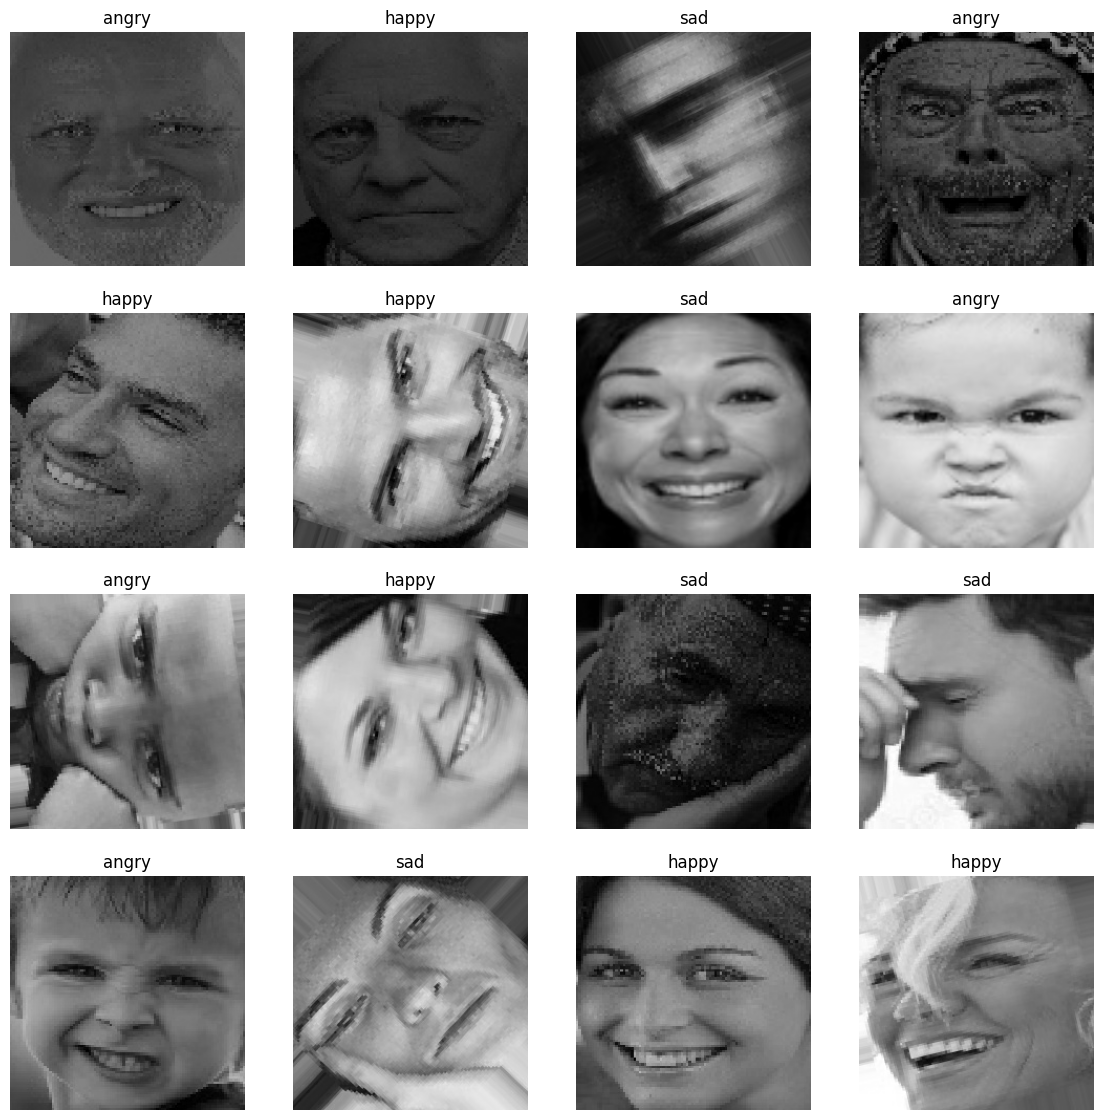

In [19]:
plt.figure(figsize = (14, 14))
for images, labels in train_dataset.take(1):
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255)
    plt.title(train_dataset.class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")

In [20]:
print(val_dataset.class_names)

['angry', 'happy', 'sad']


# DATA AUGMENTATION

## BASIC AUGMENTATION

In [21]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1)
])

def augment_layer(image, label):
  return augment_layers(image, training=True), label

## CUT MIX AUGMENTATION

In [22]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

IMG_SIZE = CONFIGURATION["IM_SIZE"]
@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

# DATASET PREPERATION

TRAIN DATASET

In [23]:
# Without Augmentation
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [24]:
# Basic Augmentation
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [25]:
# Cutmix Augmentation + Basic

train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

VALIDATION DATASET

In [26]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

# MODELLING

## LENET MODEL

In [27]:
lenet_model = tf.keras.Sequential([
    # Input Layer, as images have different shapes therefore None, None, 3
    InputLayer(input_shape=(None, None, 3)),

    # Resing & Rescaling to make each image same dimensions and normalising there value
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),

    # Convolution Layers for extracting features from images
    # Convolution layer 1
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid", activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    # Batch normaliation, to have zero meand unit variance for each mini batch and normalzing inputs to each layer
    BatchNormalization(),

    # Downsampling reducing spatial dimensions of the input tensor while learning the most prominent features
    MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),

    # dropout, regularization technique to reduce overfitting, prevent model from relying too heavily on specific neurons by randomly "droping out"
    Dropout(CONFIGURATION["DROPOUT_RATE"]),

    # Convolution layer 2
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid", activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    # Batch normaliation
    BatchNormalization(),

    # Downsampling
    MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),

    # Flatten, convert multi-dimensional input tensor into a one-dimensional tensor
    Flatten(),

    # Dense Layers for classification from extracted features
    # Dense layer 1
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(CONFIGURATION["DROPOUT_RATE"]),

    # Dense layer 2
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    # Dense layer 3
    Dense(CONFIGURATION["N_DENSE_3"], activation="softmax"),
])
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)      

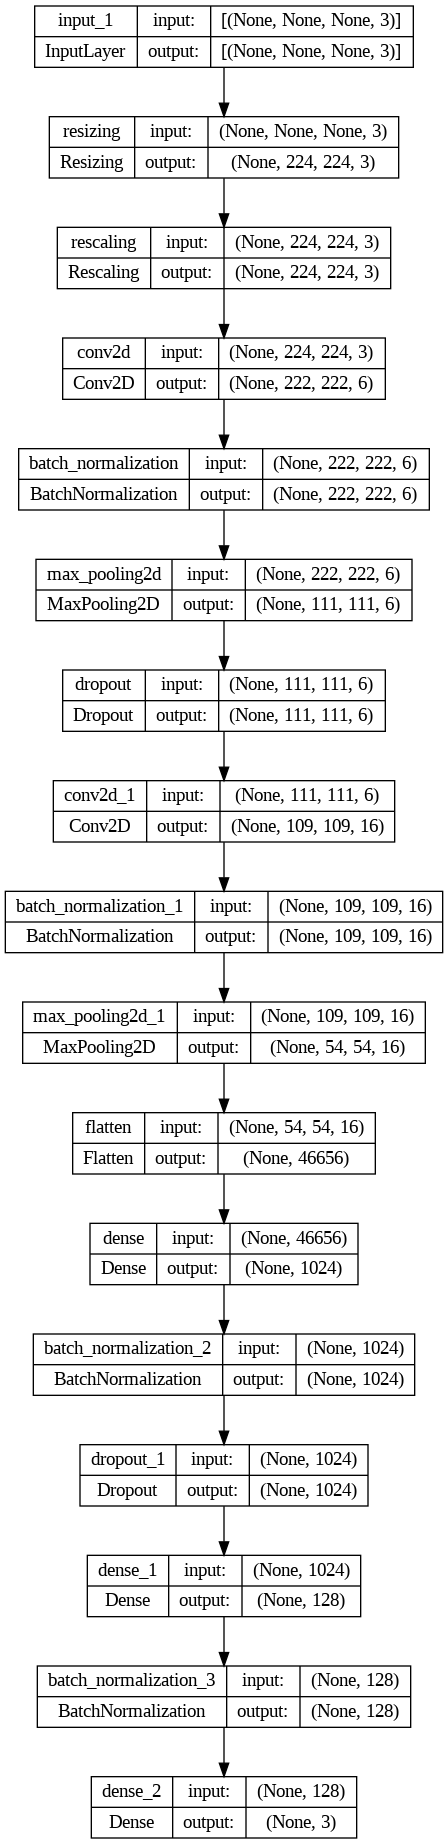

In [28]:
tf.keras.utils.plot_model(lenet_model, to_file="model.png", show_shapes=True, show_layer_names=True)

## RESNET34 (Residual Network with 34 layers) MODEL

In [29]:
class CustomConv2D(Layer):
  def __init__(self, filters, kernel_size, strides):
    super(CustomConv2D, self).__init__()
    self.conv = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="same", activation="relu")
    self.bn = BatchNormalization()

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.bn(x)

    return x


class ResidualBlock(Layer):
  def __init__(self, filters, strides=1):
    super(ResidualBlock, self).__init__(name="res_block")
    self.conv1 = CustomConv2D(filters, 3, strides)
    self.conv2 = CustomConv2D(filters, 3, 1)

    self.dotted = (strides!=1)
    if self.dotted:
      self.dimensionMatching = CustomConv2D(filters, 1, 2)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)

    if self.dotted:
      inputs = self.dimensionMatching(inputs)

    x = Add()([x, inputs])
    x = ReLU()(x)

    return x

class ResNet34(Model):
  def __init__(self):
    super(ResNet34, self).__init__(name = "resnet34")
    self.conv = CustomConv2D(64, 7, 2)
    self.max_pool = MaxPooling2D(pool_size=3, strides=2, padding="same")

    self.block1 = ResidualBlock(64)
    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)

    self.block4 = ResidualBlock(128, 2)
    self.block5 = ResidualBlock(128)
    self.block6 = ResidualBlock(128)
    self.block7 = ResidualBlock(128)

    self.block8 = ResidualBlock(256, 2)
    self.block9 = ResidualBlock(256)
    self.block10 = ResidualBlock(256)
    self.block11 = ResidualBlock(256)
    self.block12 = ResidualBlock(256)
    self.block13 = ResidualBlock(256)

    self.block14 = ResidualBlock(512, 2)
    self.block15 = ResidualBlock(512)
    self.block16 = ResidualBlock(512)

    self.avgpool = GlobalAveragePooling2D()

    self.fc = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")

  def call(self, inputs):

    x = Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])(inputs)
    x = Rescaling(1./255)(x)

    x = self.conv(x)
    x = self.max_pool(x)

    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)

    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)

    x = self.block8(x)
    x = self.block9(x)
    x = self.block10(x)
    x = self.block11(x)
    x = self.block12(x)
    x = self.block13(x)

    x = self.block14(x)
    x = self.block15(x)
    x = self.block16(x)

    x = self.avgpool(x)

    x = self.fc(x)
    return x



In [30]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,224,224,3]))
resnet_34.summary()

Model: "resnet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  231

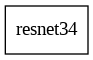

In [31]:
tf.keras.utils.plot_model(resnet_34, to_file="model.png", show_shapes=True, show_layer_names=True)

## EFFICIENTNET MODEL

### TRANSFER LEARNING

In [32]:
feature_extractor = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
)
# First Set False For Tansfer Learning then True For Fine Tunning
feature_extractor.trainable = False

71686520/71686520 [==============================] - 0s 0us/step


In [33]:
input = Input(shape=(None, None, 3))
x = Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])(input)
x = Rescaling(1./255)(x)
x = feature_extractor(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

efficient_net_model = Model(input, output)

### FINE TUNNING

In [34]:
feature_extractor_finetune = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
)
# First Set False For Tansfer Learning then True For Fine Tunning
feature_extractor_finetune.trainable = False

In [35]:
input = Input(shape=(None, None, 3))

x = Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])(input)
x = Rescaling(1./255)(x)

x = feature_extractor(x, training=False)

x = GlobalAveragePooling2D()(x)

x = Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]))(x)
x = BatchNormalization()(x)
x = Dropout(CONFIGURATION["DROPOUT_RATE"])(x)

x = Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]))(x)
x = BatchNormalization()(x)

output = Dense(CONFIGURATION["N_DENSE_3"], activation="softmax")(x)

finetuned_model = Model(input, output)

## VIT WITH HUGGINGFACE

In [36]:
!pip install transformers

In [37]:
from transformers import ViTModel, ViTConfig

In [38]:
configuration = ViTConfig()

In [39]:
model = ViTModel(configuration)

In [40]:
print(model.config)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.35.2"
}



In [41]:
from transformers import ViTFeatureExtractor, TFViTModel

In [42]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
    Permute((3,1,2))
])

In [43]:
base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
inputs = Input(shape=(None,None,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
outputs = Dense(3, activation="softmax")(x)
hf_model = tf.keras.Model(inputs=inputs, outputs=outputs)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/346M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [44]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/101883.jpg")
test_image = cv2.resize(test_image, (224, 224))

In [45]:
hf_model(tf.expand_dims(test_image, axis=0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.3114213 , 0.39116365, 0.29741505]], dtype=float32)>

In [46]:
hf_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential_2 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0   

# TRAINING

## CALLBACKS

In [47]:
checkpoint_callback = ModelCheckpoint(
    "best_weights",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)

## LOSS FUNCTIO & METRICS

In [48]:
# From logits = False, means that output vector will be a probability distribution having sum = 1
# Else we can set it True if output is raw that means it is not a pd and it is directly take from neurons output
loss_function = CategoricalCrossentropy(from_logits=False)

# Categorical accuracy  [0, 0, 1] matches with [0, 0.1, 0.9] (that is it will check whether highest value matches or not for same class)
# Top K Categorical accuracy compares how often target in top k prediction
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]


In [49]:
# Sparse Categorical
# When label mode for dataset is "int" that 0[1,0,0], 1[0,1,0], 2[0,0,1] type
# sparse_loss_functin = SparseCategoricalCrossentropy()

## LENET

In [50]:
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [51]:
history_lenet = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
)

Epoch 1/3
213/213 [==============================] - 121s 496ms/step - loss: 1.0970 - accuracy: 0.4829 - top_k_accuracy: 0.7809 - val_loss: 1.0432 - val_accuracy: 0.4662 - val_top_k_accuracy: 0.7739
Epoch 2/3
213/213 [==============================] - 95s 436ms/step - loss: 0.9768 - accuracy: 0.5499 - top_k_accuracy: 0.8178 - val_loss: 0.9759 - val_accuracy: 0.5360 - val_top_k_accuracy: 0.7954
Epoch 3/3
213/213 [==============================] - 90s 418ms/step - loss: 0.9482 - accuracy: 0.5770 - top_k_accuracy: 0.8416 - val_loss: 0.8773 - val_accuracy: 0.6071 - val_top_k_accuracy: 0.8538


## RESNET_34

In [52]:
resnet_34.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [53]:
history_resnet = resnet_34.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
)

Epoch 1/3
213/213 [==============================] - 145s 499ms/step - loss: 1.2268 - accuracy: 0.4876 - top_k_accuracy: 0.7883 - val_loss: 1.1847 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7748
Epoch 2/3
213/213 [==============================] - 101s 471ms/step - loss: 1.0384 - accuracy: 0.5013 - top_k_accuracy: 0.7964 - val_loss: 1.0596 - val_accuracy: 0.4798 - val_top_k_accuracy: 0.7581
Epoch 3/3
213/213 [==============================] - 99s 459ms/step - loss: 1.0068 - accuracy: 0.5293 - top_k_accuracy: 0.8088 - val_loss: 1.6076 - val_accuracy: 0.4688 - val_top_k_accuracy: 0.7669


## EFFICIENT NET

In [54]:
efficient_net_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics,
)

In [55]:
history_efficient_net = efficient_net_model.fit(training_dataset, validation_data=validation_dataset, epochs = 5, verbose=1)

Epoch 1/5
213/213 [==============================] - 131s 530ms/step - loss: 1.0707 - accuracy: 0.4473 - top_k_accuracy: 0.7660 - val_loss: 1.0638 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 2/5
213/213 [==============================] - 104s 480ms/step - loss: 1.0613 - accuracy: 0.4495 - top_k_accuracy: 0.7823 - val_loss: 1.0637 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 3/5
213/213 [==============================] - 111s 511ms/step - loss: 1.0649 - accuracy: 0.4405 - top_k_accuracy: 0.7689 - val_loss: 1.0627 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 4/5
213/213 [==============================] - 100s 467ms/step - loss: 1.0621 - accuracy: 0.4461 - top_k_accuracy: 0.7754 - val_loss: 1.0638 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 5/5
213/213 [==============================] - 100s 465ms/step - loss: 1.0647 - accuracy: 0.4415 - top_k_accuracy: 0.7698 - val_loss: 1.0628 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739


## FINETUNE

In [56]:
finetuned_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics,
)

In [57]:
history_finetune = finetuned_model.fit(training_dataset, validation_data=validation_dataset, epochs = 3, verbose=1)

Epoch 1/3
213/213 [==============================] - 121s 484ms/step - loss: 1.0734 - accuracy: 0.4508 - top_k_accuracy: 0.7695 - val_loss: 2.4823 - val_accuracy: 0.3248 - val_top_k_accuracy: 0.5584
Epoch 2/3
213/213 [==============================] - 102s 474ms/step - loss: 1.0398 - accuracy: 0.4783 - top_k_accuracy: 0.7876 - val_loss: 8.0005 - val_accuracy: 0.2261 - val_top_k_accuracy: 0.5584
Epoch 3/3
213/213 [==============================] - 102s 473ms/step - loss: 1.0262 - accuracy: 0.4885 - top_k_accuracy: 0.7903 - val_loss: 7.8396 - val_accuracy: 0.3336 - val_top_k_accuracy: 0.5579


In [58]:
feature_extractor_finetune.trainable = True

In [59]:
history_finetune_ = finetuned_model.fit(training_dataset, validation_data=validation_dataset, epochs = 3, verbose=1)

Epoch 1/3
213/213 [==============================] - 100s 464ms/step - loss: 1.0278 - accuracy: 0.4889 - top_k_accuracy: 0.7978 - val_loss: 20.4900 - val_accuracy: 0.3323 - val_top_k_accuracy: 0.5584
Epoch 2/3
213/213 [==============================] - 102s 468ms/step - loss: 1.0211 - accuracy: 0.4924 - top_k_accuracy: 0.7979 - val_loss: 4.8676 - val_accuracy: 0.3670 - val_top_k_accuracy: 0.7739
Epoch 3/3
213/213 [==============================] - 115s 525ms/step - loss: 1.0175 - accuracy: 0.5046 - top_k_accuracy: 0.7917 - val_loss: 12.2601 - val_accuracy: 0.3323 - val_top_k_accuracy: 0.5571


## ViT Huggingface

In [60]:
hf_model.compile(
    optimizer=Adam(CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics,
)

In [61]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    true_labels = []
    predicted_labels = []
    for batch_images, batch_labels in validation_dataset:
      true_labels.extend(tf.argmax(batch_labels, axis=-1).numpy().tolist())
      predicted_labels.extend(tf.argmax(hf_model(batch_images), axis=-1).numpy().tolist())

    cm = wandb.plot.confusion_matrix(
        y_true = true_labels,
        preds = predicted_labels,
        class_names = CONFIGURATION["CLASS_NAMES"]
    )
    wandb.log({"conf_mat": cm})


In [62]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):
    columns = ["Image", "Predicted", "Label"]
    val_table = wandb.Table(columns=columns)
    for batch_images, batch_labels in validation_dataset.take(1):
      for image, label in zip(batch_images, batch_labels):
        true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label).numpy()]
        predicted_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(tf.expand_dims(image, axis=0)), axis=-1).numpy()[0]]
        row = [wandb.Image(image), predicted_label, true_label]
        val_table.add_data(*row)
    wandb.log({"Model Results": val_table})

In [63]:
history_hf_model = hf_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs = 5,
    verbose=1,
    callbacks=[WandbCallback(), LogConfMatrix(), LogResultsTable(), LogResultsTable()]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5


213/213 [==============================] - ETA: 0s - loss: 1.0703 - accuracy: 0.4158 - top_k_accuracy: 0.7163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231128_134517-wibdywql/files/model-best)... Done. 101.1s


213/213 [==============================] - 673s 3s/step - loss: 1.0703 - accuracy: 0.4158 - top_k_accuracy: 0.7163 - val_loss: 1.0605 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 2/5
213/213 [==============================] - ETA: 0s - loss: 1.0644 - accuracy: 0.4499 - top_k_accuracy: 0.7613

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231128_134517-wibdywql/files/model-best)... Done. 164.0s


213/213 [==============================] - 775s 4s/step - loss: 1.0644 - accuracy: 0.4499 - top_k_accuracy: 0.7613 - val_loss: 1.0457 - val_accuracy: 0.4860 - val_top_k_accuracy: 0.7739
Epoch 3/5
213/213 [==============================] - 365s 2s/step - loss: 1.0549 - accuracy: 0.4627 - top_k_accuracy: 0.7747 - val_loss: 1.0506 - val_accuracy: 0.4570 - val_top_k_accuracy: 0.7739
Epoch 4/5
213/213 [==============================] - ETA: 0s - loss: 1.0546 - accuracy: 0.4611 - top_k_accuracy: 0.7742

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231128_134517-wibdywql/files/model-best)... Done. 220.4s


213/213 [==============================] - 926s 4s/step - loss: 1.0546 - accuracy: 0.4611 - top_k_accuracy: 0.7742 - val_loss: 1.0395 - val_accuracy: 0.4939 - val_top_k_accuracy: 0.7739
Epoch 5/5
213/213 [==============================] - ETA: 0s - loss: 1.0494 - accuracy: 0.4707 - top_k_accuracy: 0.7766

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231128_134517-wibdywql/files/model-best)... Done. 331.3s


213/213 [==============================] - 1279s 6s/step - loss: 1.0494 - accuracy: 0.4707 - top_k_accuracy: 0.7766 - val_loss: 1.0276 - val_accuracy: 0.4991 - val_top_k_accuracy: 0.7752


# EVALUATION

In [64]:
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 3s 29ms/step - loss: 0.8773 - accuracy: 0.6071 - top_k_accuracy: 0.8538


[0.8772543668746948, 0.6071115136146545, 0.8538191318511963]

In [65]:
resnet_34.evaluate(validation_dataset)

72/72 [==============================] - 5s 67ms/step - loss: 1.6076 - accuracy: 0.4688 - top_k_accuracy: 0.7669


[1.607583999633789, 0.4688323140144348, 0.7669007778167725]

In [66]:
efficient_net_model.evaluate(validation_dataset)

72/72 [==============================] - 12s 162ms/step - loss: 1.0628 - accuracy: 0.4416 - top_k_accuracy: 0.7739


[1.0628341436386108, 0.4416154623031616, 0.7739244699478149]

In [67]:
finetuned_model.evaluate(validation_dataset)

72/72 [==============================] - 12s 167ms/step - loss: 12.2601 - accuracy: 0.3323 - top_k_accuracy: 0.5571


[12.260130882263184, 0.3323090374469757, 0.5570676326751709]

In [68]:
hf_model.evaluate(validation_dataset)

72/72 [==============================] - 33s 450ms/step - loss: 1.0276 - accuracy: 0.4991 - top_k_accuracy: 0.7752


[1.0276358127593994, 0.4991220235824585, 0.7752414345741272]

# VISUALIZING RESULTS OF TRAINING

## Plotting function

In [1]:
def plot_loss_accuracy(history, title):
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title(f"{title} : LOSS V/S EPOCH")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Train", "Val"])
  plt.show()

  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title(f"{title} : Accuracy V/S EPOCH")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(["Train", "Val"])
  plt.show()

### LENET MODEL

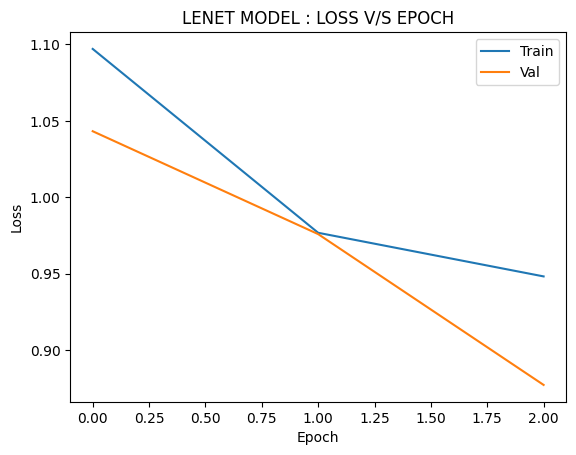

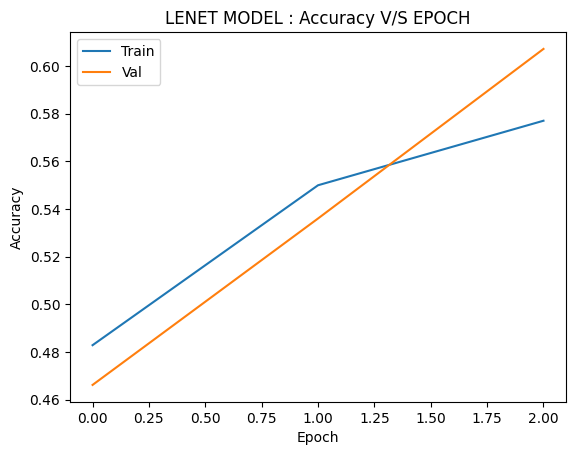

In [70]:
plot_loss_accuracy(history_lenet, "LENET MODEL")

### RESNET

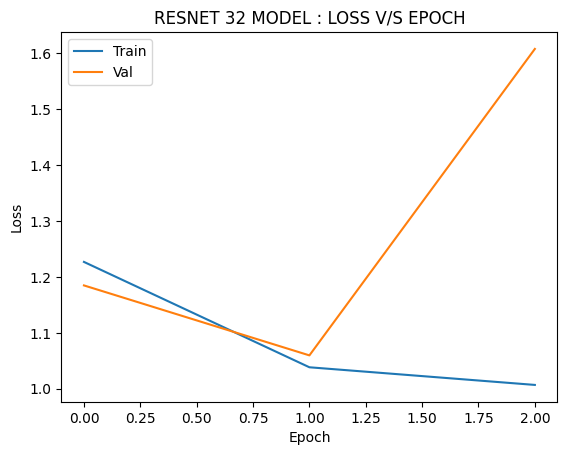

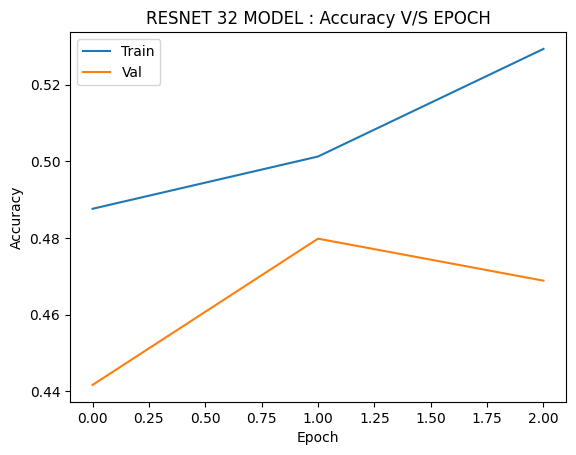

In [71]:
plot_loss_accuracy(history_resnet, "RESNET 32 MODEL")

### EFFICIENT NET

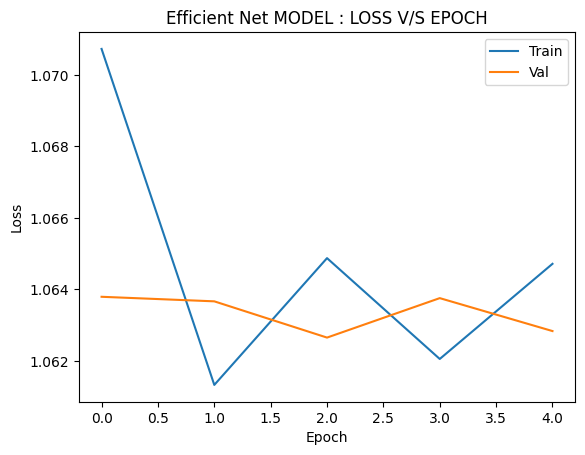

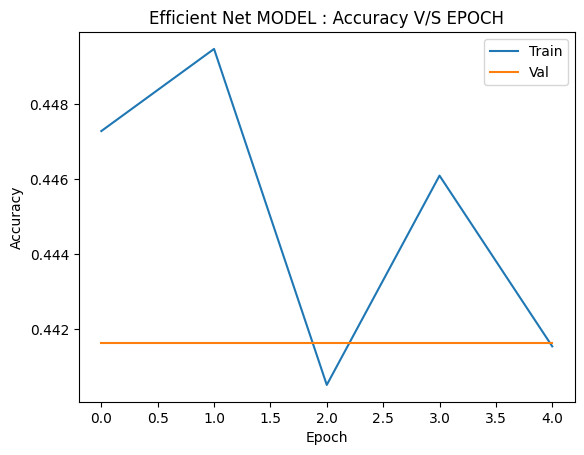

In [72]:
plot_loss_accuracy(history_efficient_net, "Efficient Net MODEL")

### FINETUNED

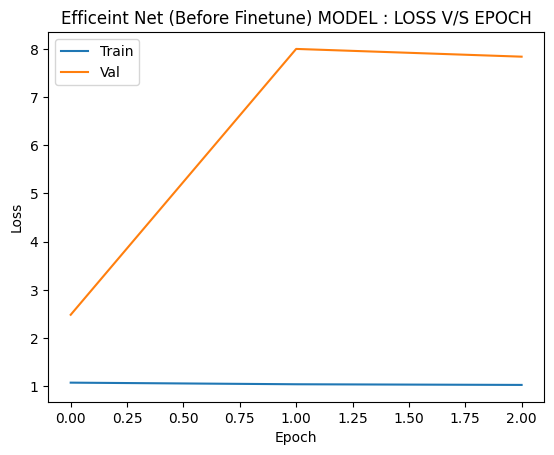

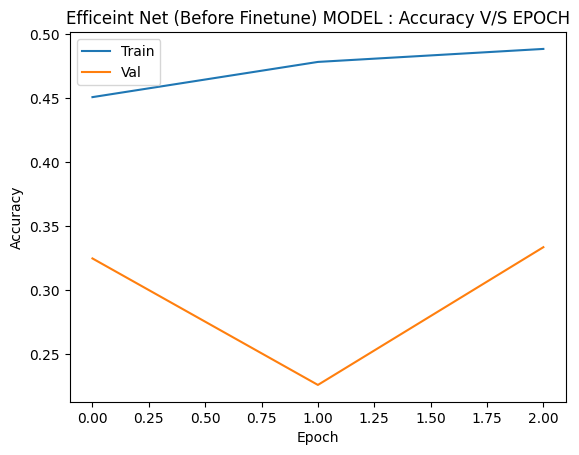

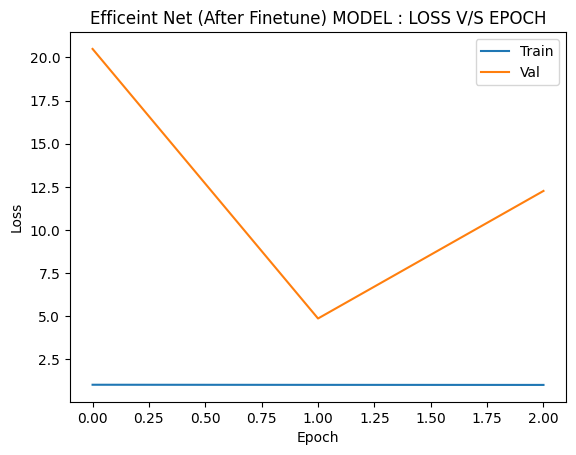

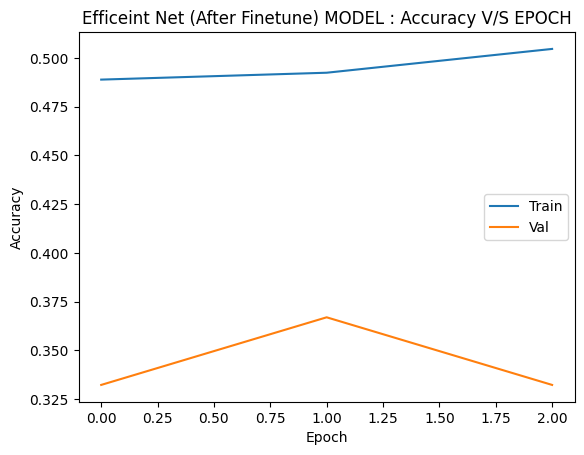

In [73]:
plot_loss_accuracy(history_finetune, "Efficeint Net (Before Finetune) MODEL")
plot_loss_accuracy(history_finetune_, "Efficeint Net (After Finetune) MODEL")

### ViT Huggingface

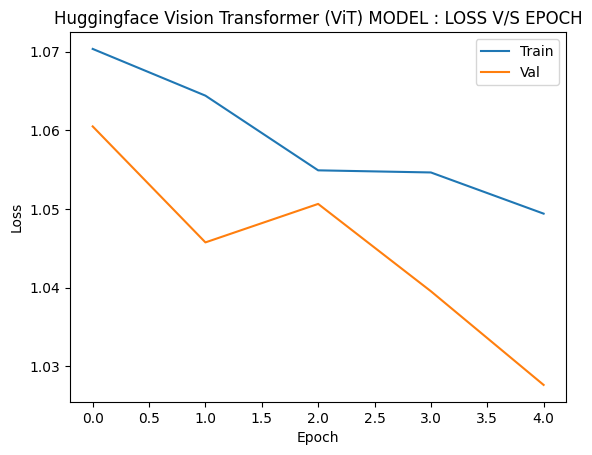

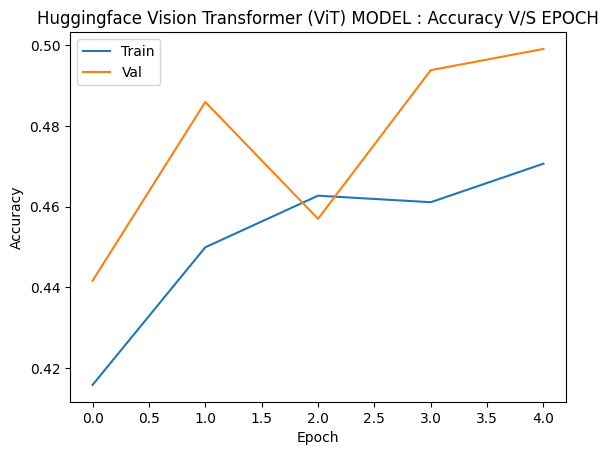

In [74]:
plot_loss_accuracy(history_hf_model, "Huggingface Vision Transformer (ViT) MODEL")

# TESTING

1/1 [==============================] - 0s 67ms/step


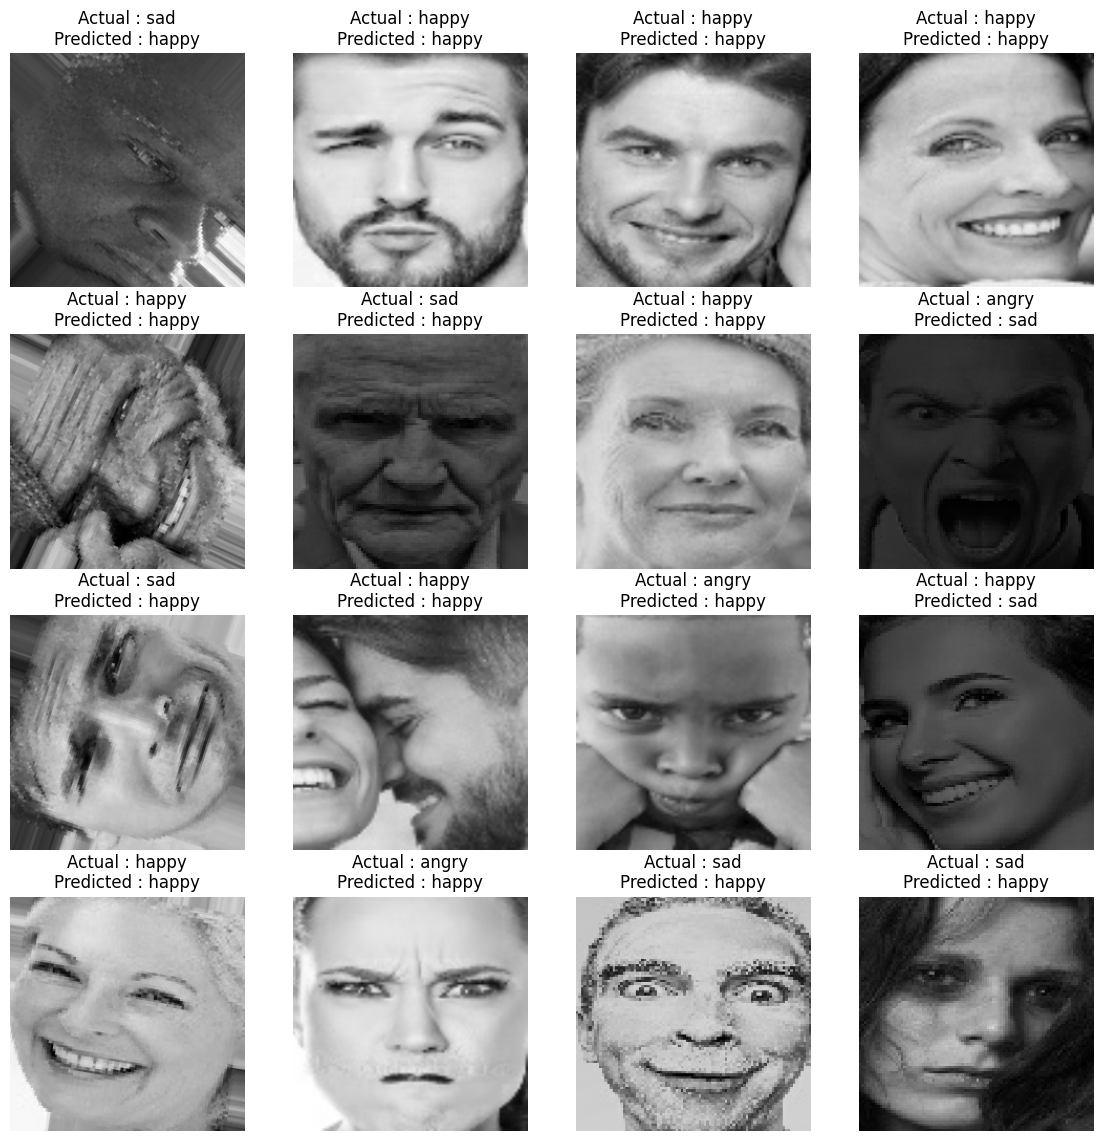

In [75]:
plt.figure(figsize = (14, 14))
for images, labels in val_dataset.take(1):
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255)
    plt.title("Actual : " + CLASS_NAMES[tf.argmax(labels[i]).numpy()] + "\nPredicted : " + CLASS_NAMES[tf.argmax(hf_model.predict(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])
    plt.axis("off")

# PERFORMANCE

## CONFUSION MATRIX

In [76]:
true_labels = []
predicted_labels = []

In [77]:
for batch_images, batch_labels in validation_dataset:
  true_labels.extend(tf.argmax(batch_labels, axis=-1).numpy().tolist())
  predicted_labels.extend(tf.argmax(lenet_model.predict(batch_images), axis=-1).numpy().tolist())

1/1 [==============================] - 0s 129ms/step


In [78]:
print(true_labels)
print(len(true_labels))

[2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 2, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 1, 1, 0, 2, 2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 1, 0, 0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 1, 1, 2, 2, 1, 1, 2, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 2, 0, 1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 

In [79]:
print(predicted_labels)
print(len(predicted_labels))

[1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

In [80]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[121, 250, 144],
       [ 25, 865, 116],
       [ 38, 322, 397]])

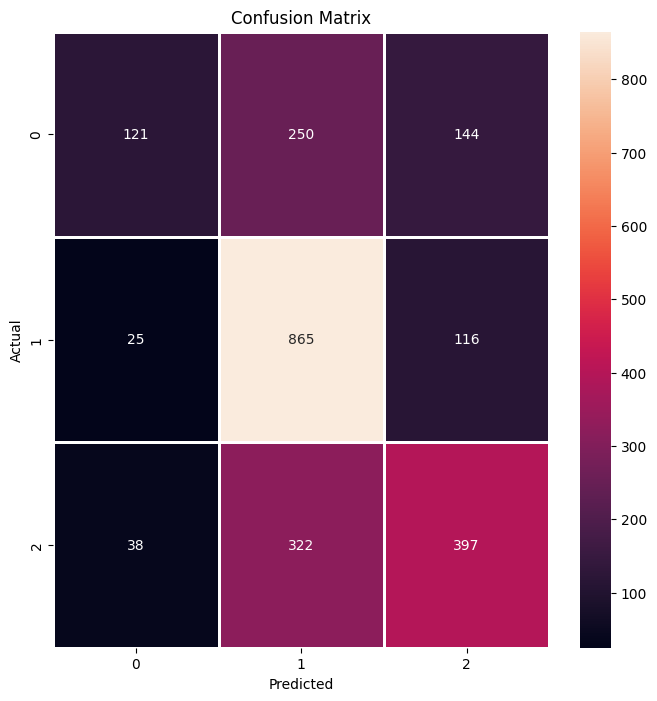

In [81]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", linewidths=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# VISUALISING INTERMEDIATE CONVOLUTION LAYERS

In [82]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)
)
vgg_backbone.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [83]:
def is_conv(layer_name):
  if "conv" in layer_name:
    return True
  return False

In [84]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]

In [85]:
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)
feature_map_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [86]:
print(len(feature_maps))

13


In [87]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg")
test_image = cv2.resize(test_image, (224, 224))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 1s 934ms/step


In [88]:
print(len(f_maps))

13


In [89]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 224, 224, 64)
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)


In [2]:
for i in range(3):
  plt.figure(figsize=(224, 224))
  n_channels = f_maps[i].shape[3]
  size = f_maps[i].shape[1]
  joint_maps = np.ones((size, size*n_channels))

  plt.subplot(3, 1, i+1)
  for j in range(n_channels):
    joint_maps[:, size*j:size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:, 0:448])
  plt.axis("off")

NameError: ignored

# Saving And Loading Model (Google Drive)

In [ ]:
hf_model.save("vit_finetuned")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/drive/MyDrive/MyViTModel/ /content/vit_finetuned/

In [ ]:
my_vit_model = tf.keras.models.load_model("/content/vit_finetuned")

In [ ]:
my_vit_model.evaluate(validation_dataset)

# Export into ONNX Format

## Installation

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime

## Conversion From tensorflow to onnx

In [ ]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

In [ ]:
!cp -r /content/drive/MyDrive/vit_onnx.onnx /content/vit_onnx.onnx

## Predicting Using Onnx Model

In [ ]:
import onnxruntime as rt

In [ ]:
!pip install onnx

In [ ]:
import onnx
model = onnx.load("/content/vit_onnx.onnx")

In [ ]:
import onnxruntime as ort
session = ort.InferenceSession("/content/vit_onnx.onnx")

In [ ]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [ ]:
input_data = cv2.imread("/content/111073.jpg")
input_data = cv2.resize(input_data, (224, 224))
input_data = tf.expand_dims(tf.cast(input_data, tf.float32), axis=0).numpy()

In [ ]:
output = session.run([output_name], {input_name: input_data})

In [ ]:
print(output)

# Creating Web Interface Using Gradio

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
!pip install onnx
!pip install onnxruntime

In [ ]:
import onnxruntime as rt

In [ ]:
import onnx
model = onnx.load("/content/vit_onnx.onnx")

In [ ]:
import onnxruntime as ort
session = ort.InferenceSession("/content/vit_onnx.onnx")

In [ ]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [ ]:
CLASS_NAMES = ["Angry", "Happy", "Sad"]
def predict_image(im):
  im = tf.expand_dims(tf.cast(im, tf.float32), axis=0).numpy()
  prediction = session.run([output_name], {input_name: im})
  return {CLASS_NAMES[i]: float(prediction[0][0][i]) for i in range(3)}

In [ ]:
image = gr.inputs.Image(shape=(224, 224))
label = gr.outputs.Label(num_top_classes=3)
iface = gr.Interface(fn=predict_image, inputs=image, outputs=label, capture_session=True)
iface.launch(debug="True")

# VISION TRANSFORMERS

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/110028.jpg")

In [ ]:
test_image = cv2.resize(test_image, (256, 256))

In [ ]:
plt.imshow(test_image)

In [ ]:
patches = tf.image.extract_patches(
    images=tf.expand_dims(test_image, axis=0),
    sizes=[1, 16, 16, 1],
    strides=[1, 16, 16, 1],
    rates=[1, 1, 1, 1],
    padding="VALID"
)

In [ ]:
patches.shape

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (1,256,768))
print(patches.shape)

In [ ]:
for i in range(patches.shape[1]):
    plt.subplot(16, 16, i+1)
    im = patches[0][i][j]
    plt.imshow(tf.reshape(patches[0][i], (16,16,3)))
    plt.axis("off")


In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name="patch_encoder")
    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding()
  def call(self, inputs):
    patches = tf.image.extract_patches(
        images=inputs,
        sizes=[1, 16, 16, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
    ouput = self.linear_projection(patches)


LOSS

In [ ]:
plt.plot(history_hf_model.history["loss"])
plt.plot(history_hf_model.history["val_loss"])
plt.title("LOSS V/S EPOCH")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])

ACCURACY

In [ ]:
plt.plot(history_hf_model.history["accuracy"])
plt.plot(history_hf_model.history["val_accuracy"])
plt.title("LOSS V/S EPOCH")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])

In [ ]:
hf_model.evaluate(validation_dataset)